Computer: server
/experiment/export_data/data_play/ZKawakeM72_013_e_010_spikes.mat
/experiment/export_data/data_play/ZKawakeM72_013_f_010_spikes.mat
['ZKawakeM72_013_f_010', 'ZKawakeM72_013_e_010']
['/experiment/export_data/data_play/ZKawakeM72_013_f_trial.mat', '/experiment/export_data/data_play/ZKawakeM72_013_e_trial.mat']
/experiment/export_data/data_play/ZKawakeM72_013_f_trial.mat
/experiment/export_data/data_play/ZKawakeM72_013_e_trial.mat
['/experiment/export_data/data_play/ZKawakeM72_013_f_noStimSniff.mat', '/experiment/export_data/data_play/ZKawakeM72_013_e_noStimSniff.mat']
/experiment/export_data/data_play/ZKawakeM72_013_f_noStimSniff.mat
/experiment/export_data/data_play/ZKawakeM72_013_e_noStimSniff.mat
/experiment/export_data/data_play/ZKawakeM72_013_e_011_spikes.mat
['ZKawakeM72_013_e_011']
[]
[]


[{'ax_stack': <matplotlib.figure.AxesStack at 0x7f53f42876d0>,
  'fig': None,
  'figure': <matplotlib.figure.Figure at 0x7f540a62d610>},
 {'ax_stack': <matplotlib.figure.AxesStack at 0x7f540a6b0b50>,
  'fig': None,
  'figure': <matplotlib.figure.Figure at 0x7f540033ad50>},
 {'ax_stack': <matplotlib.figure.AxesStack at 0x7f540a4ccb10>,
  'fig': None,
  'figure': <matplotlib.figure.Figure at 0x7f540a5e8a10>}]

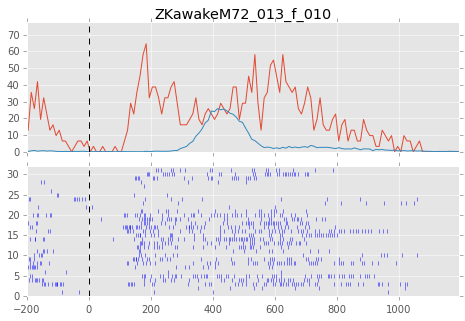

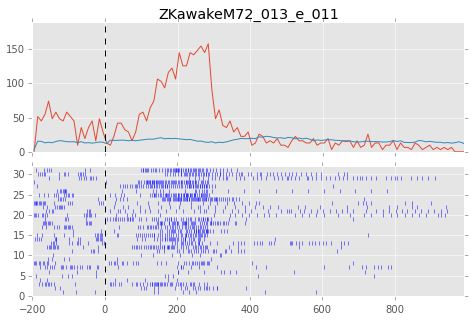

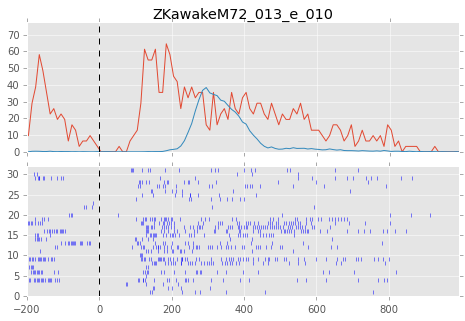

In [157]:
%matplotlib inline
from __future__ import division
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os

matplotlib.style.use('ggplot')

comp_name=socket.gethostname()
if  comp_name == 'Ezequiels-MacBook-Pro.local':
    print 'Computer: ' + comp_name
    sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/Users','zeke','experiment')
else:
    print 'Computer: ' + 'server'
    sys.path.append('/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/','experiment')
    
import unitToolsv2
from data_handling import ephys_names as en
from data_handling.basic_plot import decim, plot_raster, make_psth
from data_handling import data_load as dl
from analysis import stimulus as st

#load all the records, to not load all the records for every stimulus
fn = en.file_names(root = experiment_folder)
cells_path = os.path.join(fn.fold_exp_data, 'data_play')
all_records = dl.load_cells(cells_path)

## create a stimulus and initialize it (load its responses)
high_2hydroxy = st.Odor(['2-hydroxyacetophenone','2hydroxyacetophenone'], 0.0051)
st_1 = st.Stimulus(high_2hydroxy, records = all_records, tags = {'light':1} )
#get the first response and plot it
[r.plot(warped=True) for r in list(st_1.responses.values())]
#st_1.responses['ZKawakeM72_013_e_010'].plot(warped=False)

In [6]:
r0=st_1.responses['ZKawakeM72_013_e_010']
dir(st_1.responses['ZKawakeM72_013_e_010'])

['__doc__',
 '__init__',
 '__module__',
 'all_spikes',
 'all_trials',
 'base_sniff',
 'baseline',
 'make_raster',
 'plot',
 'raster',
 'raster_plot',
 'rec']

In [29]:
print r0.raster.keys()
print r0.all_trials['ZKawakeM72_013_f_2766487'].keys()
trial['sniff_zero'][0]

['spikes', 'concs', 't_2', 'trialId', 't_0', 't_1', 'odors']
['start', 'sess', 'sniff_zero', 'sniff_flow', 'rec', 'mouse', 'odor', 'rec_id', 'odor_c', 'odor_t']


array([-5031, -4332, -3624, -2919, -2189, -1438,  -722,    -2,   728,
        1376,  2170,  2913,  3714,  4376,  5141,  5901])

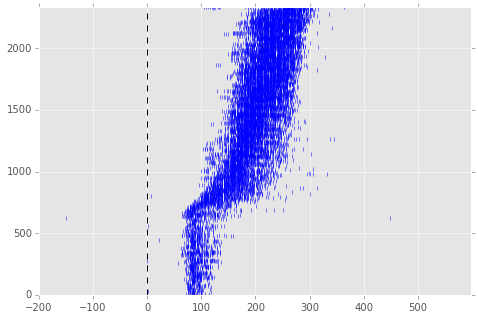

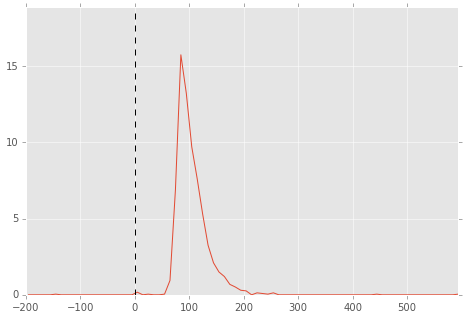

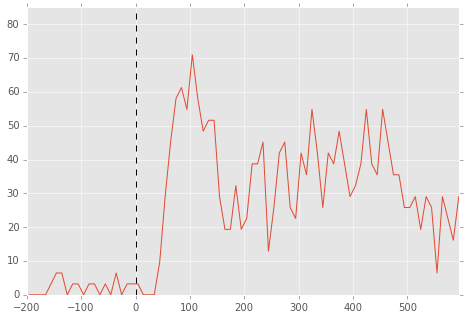

In [13]:
rec_name = 'ZKawakeM72_013_e_010'
r0=st_1.responses[rec_name]
rst = r0.make_raster(warped=False)
#plot_raster(rst, t0=200)
#plot_raster(rst, bin_size=10, t0=200)
bl=r0.baseline.make_raster(t_pre=200, t_post=800, warped=False)
plot_raster(bl, t0=200)
plot_raster(bl, t0=200, bin_size=10)
plot_raster(rst, t0=200, bin_size=10)
bin_size = 10
events   = bl.shape[0]
t_stamps = bl.shape[1]
t=np.arange(t_stamps)-200
t_dec = decim(t, bin_size)


([<matplotlib.lines.Line2D at 0x7fd7b55836d0>],
 <matplotlib.axes._axes.Axes at 0x7fd7b94373d0>)

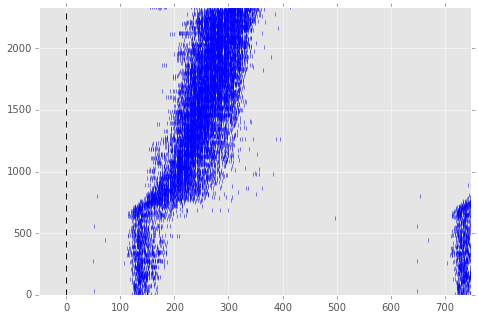

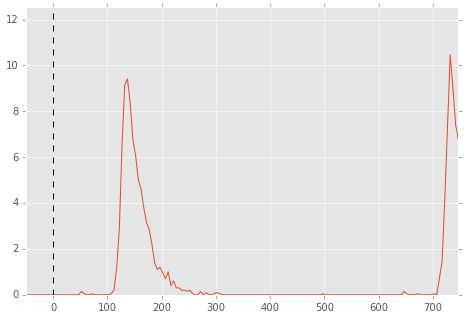

In [8]:
dir(r0.baseline)
plot_raster(r0.baseline.make_raster(t_post=800, warped=False),t0=50)
plot_raster(r0.baseline.make_raster(t_post=800, warped=False),t0=50, bin_size = 5)

In [17]:
mat_file_path='/Users/zeke/experiment/export_data/ZKawakeM72_013_e_011_spikes.mat'
assert(os.path.isfile(mat_file_path))
print (mat_file_path)
spike_data = sio.loadmat(mat_file_path, struct_as_record=False, squeeze_me=True)
spikes_loaded = spike_data['thisUnit']
all_spikes = np.array(spikes_loaded.times, dtype=np.float)

/Users/zeke/experiment/export_data/ZKawakeM72_013_e_011_spikes.mat


In [66]:
from scipy.stats import ks_2samp, wilcoxon, kruskal, norm
np.random.seed(12345678)
n1=30
n2=2000
x = norm.rvs(size=n1, loc=0., scale=1)
y = norm.rvs(size=n2, loc=0.5, scale=1)
print kruskal(x,y)
print ks_2samp(x,y)

(1.7653132447067037, 0.1839631670832832)
(0.21933333333333338, 0.10032430713567805)


In [77]:
# initialize ipython "cluster" first.
# this connects client to the cluster workers.

from IPython.parallel import Client
C = Client(profile='default')
lbv = C.load_balanced_view()

In [217]:
# I'm defining the draw_and_mean as a nested function here because

def parfunc(stimulus_sa, baseline_sa):
    """
    stimulus_sa: numpy array of shape (n_bins, n_trials)
    
    """
    import numpy as np
    from scipy.stats import ks_2samp
    
    def draw_and_mean(spike_array, n_bs, n_trials):
        # draw= np.empty_like(bl_sa)
        draw_indexes = np.random.randint(0, spike_array.shape[1]-1, (n_bs, n_trials))
        psths = np.empty((n_bs, spike_array.shape[0]))
        for i in xrange(n_bs):
            draw_is = draw_indexes[i]
            draw = spike_array[:, draw_is]
            psths[i, :] = draw.mean(axis=1)
        return psths
    
    """
    sa is a tuple of two spike arrays: (stimulus_spike_array, baseline_spike_array)
    spike arrays are each numpy.array of shape (n_bins, n_trials) (for baseline it's actually n_sniffs instead of trials)
    spike arrays here are normalized (Hz).
    """
    assert(stimulus_sa.shape[0]==baseline_sa.shape[0])
    
    response_mean = stimulus_sa.mean(axis=1)
    ntr = stimulus_sa.shape[1] # number of trials in stimulus.
    baseline_boot = draw_and_mean(baseline_sa, 100000, ntr)

    ps = np.empty_like(response_mean)
    ks = np.empty_like(response_mean)
    
    for j in xrange(len(response_mean)):
        r = response_mean[j]
        base = baseline_boot[:, j]
    #     print base.shape
        p = np.sum(base >= r)/len(base)
        ps[j] = p
        _, ks[j] = ks_2samp(stimulus_sa[j,:],baseline_sa[j,:])
    ps = np.asarray(ps)
    

    
    return ps, baseline_boot, ks

In [292]:
rst_sa = col_binned(rst, 5).transpose()
bl_sa = col_binned(bl,5).transpose()
ps, psths, ks = parfunc(rst_sa, bl_sa)
response_mean = rst.transpose().mean(axis=1)

In [149]:
response_mean = rst.transpose().mean(axis=1)
pps = np.empty_like(response_mean)
for j in xrange(len(response_mean)):
    r = response_mean[j]
    base = psths[:, j]
#     print base.shape
    p = np.sum(base >= r) / len(base)
    pps[j] = p
    
pps = np.asarray(pps)

In [184]:
bl.transpose().shape[1]
draw_indexes = np.random.randint(0, bl.transpose().shape[1]-1, (1, 31))

In [208]:
bl.transpose()[3,:].shape

(2336,)

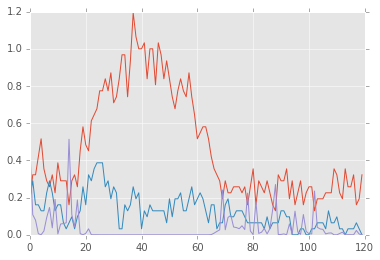

In [297]:
plt.plot(rst_sa.mean(axis=1))
plt.plot(psths[350, :])
#plt.plot(psths.mean(axis=0))
plt.plot(ps)

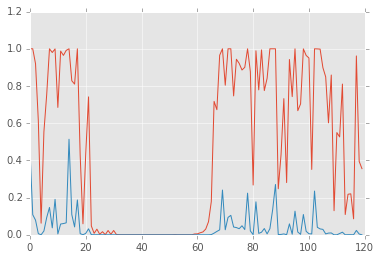

In [298]:
plt.plot(ks)
plt.plot(ps)

In [299]:
min(ps[0:20])

0.00019000000000000001

In [300]:
min(ps[20:30])

0.0

(<matplotlib.collections.PathCollection at 0x7f54003f4e90>,
 <matplotlib.axes._axes.Axes at 0x7f5400474510>)

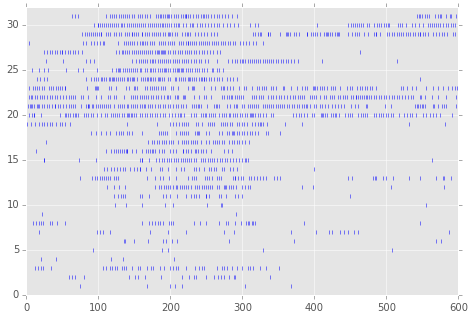

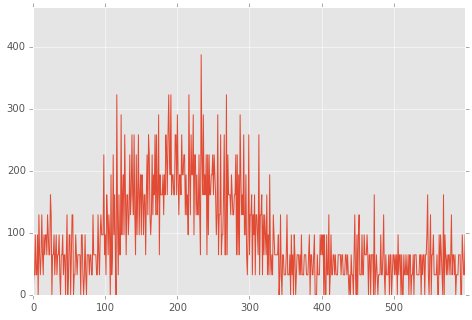

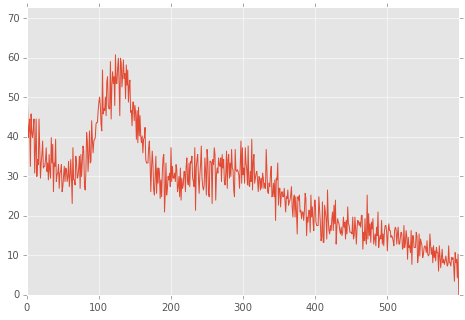

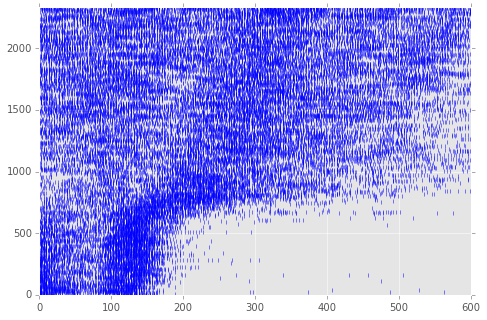

In [188]:
rec_name = 'ZKawakeM72_013_e_011'
r0=st_1.responses[rec_name]
rst = r0.make_raster(t_pre=0, t_post=600, warped=False)
plot_raster(rst, t0=0)
plot_raster(rst, bin_size=1, t0=0)
bl=r0.baseline.make_raster(t_pre=0, t_post=600, warped=False)
plot_raster(bl, bin_size=1, t0=0)
plot_raster(bl, t0=0)

#get the p values for the raster

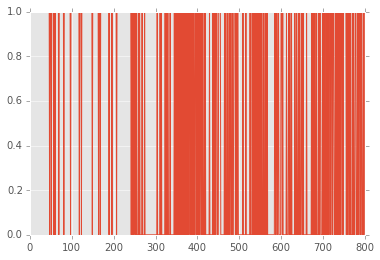

In [102]:
plt.plot(ps)

In [103]:
ps

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [289]:

## bin the array in columns
def col_binned(a, bs):
    # a: rectangular array shape (n, m)
    # bs: size for bin columns
    # output : array (n, o=m//bs)
    # if m<o*bs, those columns are padded with zeros
    
    n = a.shape[0]
    m = a.shape[1]
    o = np.ceil(m/bs)

    pad = np.empty([n, o*bs - m])*np.nan
    padded = np.append(a, pad, axis=1)
    return np.nansum(padded.reshape(n,o,bs), axis=2)

In [291]:
a = np.arange(28).reshape((4,7))
print a

print col_binned(a, 4)


[[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]]
[[  6.  15.]
 [ 34.  36.]
 [ 62.  57.]
 [ 90.  78.]]


In [281]:
np.empty([3, 4])

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

array([[ 0,  1,  2,  3,  4,  5],
       [ 7,  8,  9, 10, 11, 12],
       [14, 15, 16, 17, 18, 19],
       [21, 22, 23, 24, 25, 26]])

In [276]:
o

4.0